In [1]:
import sys
import pickle
sys.path.insert(0,'./')
import pyccl as ccl
# from importlib import reload

In [2]:
x={1:1,0:0}
1+ (x.get(1) or 0)

2

In [3]:
from distributed import LocalCluster
from dask.distributed import Client  # we already had this above
#http://distributed.readthedocs.io/en/latest/_modules/distributed/worker.html
LC=LocalCluster(n_workers=1,processes=False,memory_limit='25gb',threads_per_worker=10,memory_spill_fraction=.99,
               memory_monitor_interval='2000ms')
client=Client(LC)

In [4]:
client

Client Scheduler: inproc://136.152.250.183/7566/1 Dashboard: http://localhost:8787/status,Cluster Workers: 1 Cores: 10 Memory: 25.00 GB


In [5]:
from cov_3X2 import *
from fisher import *

In [6]:
#only for python3
import importlib
reload=importlib.reload

# Lensing X Lensing Correlation function covariance

## Multiple redshift bins (Tomography)

In [7]:
import cov_utils
reload(cov_utils)
from cov_utils import *

In [8]:
import cov_3X2
reload(cov_3X2)
from cov_3X2 import *
from wigner_transform import *

In [9]:
import hankel_transform
from astropy.io import fits
reload(hankel_transform)
from hankel_transform import *


In [10]:
cosmo_params={'h': 0.8433,
 'Omb': 0.062,
 'Omd': 0.2837-0.062,
 's8': 0.795431,
 'Om': 0.2837,
 'As': 1.685e-09,
 'mnu': 0.0,
 'Omk': 0.0,
 'tau': 0.06,
 'ns': 0.96859,
 'w': -1,
 'wa': 0,
 'Oml': 1.-0.2837}
PS=Power_Spectra(cosmo_params=cosmo_params)
k,pk,s8=PS.camb_pk(z=[0],cosmo_params=cosmo_params,return_s8=True)
s8

0.7971166462048332

In [11]:
mnu=cosmo_h.m_nu*0
cosmo=cosmo.clone(m_nu=mnu,Ob0=cosmo_params['Omb'],Om0=cosmo_params['Om'])
cosmo_h=cosmo.clone(H0=100) #,m_nu=mnu,Ob0=cosmo_params['Omb'],Om0=cosmo_params['Om'])
ccl_cosmo = ccl.Cosmology(Omega_c=cosmo_params['Omd'], Omega_b=cosmo_params['Omb'], 
                      h=cosmo_params['h'], A_s=cosmo_params['As'], n_s=cosmo_params['ns'],)#m_nu=[0,0,0.06])

In [12]:
use_window=True
do_sample_variance=True
SSV_cov=False
tidal_SSV=True
sigma_gamma=0.3944/sqrt(2.)  #*2**0.25

In [299]:
f_sky=0.1#3000./(4*np.pi/d2r**2)
f_sky

0.1

In [300]:
zmin=0.3
zmax=2

z=np.linspace(0,5,200)
pzs=lsst_pz_source(z=z)
x=z<zmax
x*=z>zmin
z=z[x]
pzs=pzs[x]

ns0=26 #26+np.inf #ns=inf means shape noise is zero
nbins=1  # Number of tomographic bins
z_sigma=0.03
zs_bins=source_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,use_window=use_window,f_sky=f_sky,
                         ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
                        zp_sigma=z_sigma*np.ones_like(z))

ng0=10 #26+np.inf #ns=inf means shape noise is zero
nlbins=1  # Number of tomographic bins
z_sigma=0.005
zl_bins=source_tomo_bins(zp=z,p_zp=pzs,ns=ng0,nz_bins=nlbins,use_window=use_window,f_sky=f_sky,
                         ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
                        zp_sigma=z_sigma*np.ones_like(z))
for i in np.arange(nlbins):
    zl_bins[i]['b1']=1

/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
./cov_utils.py:81: RuntimeWarning: invalid value encountered in true_divide
  Win0=2*jn(1,l_th)/l_th
./angular_power_spectra.py:23: RuntimeWarning: divide by zero encountered in true_divide
  self.cl_f=(l+0.5)**2/(l*(l+1.)) # cl correction from Kilbinger+ 2017
/usr/lib/python3.7/site-packages/healpy/sphtfunc.py:390: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [301]:
do_xi=True
bin_xi=True
do_cov=True
bin_cl=True
th_min=2.5/60
th_max=250./60
n_th_bins=20
th_bins=np.logspace(np.log10(th_min),np.log10(th_max),n_th_bins+1)
th=np.logspace(np.log10(th_min*0.98),np.log10(1),n_th_bins*30)
th2=np.linspace(1,th_max*1.02,n_th_bins*30)
# th2=np.logspace(np.log10(1),np.log10(th_max),60*6)
th=np.unique(np.sort(np.append(th,th2)))
thb=np.sqrt(th_bins[1:]*th_bins[:-1])

In [367]:
#Hankel Transform setup
l_max=5e2
l_maxW=5e2
l_min=2

# l0=np.logspace(np.log10(l_min),np.log10(l_maxW),1.e2)
l0=np.arange(l_min,l_max)
l0=np.unique(np.int32(l0))   #np.arange(l_min,l_max)
# l0=np.unique(np.int32(np.logspace(np.log10(l_min),np.log10(l_maxW),4.e3)))   #np.arange(l_min,l_max)
# l_bins=np.unique(np.int32(np.logspace(np.log10(l_min),np.log10(l_max),50)))
l_bins=np.unique(np.int32(np.linspace(l_min,l_max,50)))
prune_theta=0
HT_kwargs={'l_min':l_min,  'l_max':l_max,
                        'theta_min':th_min*d2r*.9, 'theta_max':th_max*d2r,
                        'n_zeros':40000, 'prune_theta':prune_theta, 'm1_m2':[(2,2),(2,-2),(0,2),(0,0)]}
# %time HT=hankel_transform(**HT_kwargs)
# HT_kwargs2={'l_min':l_min,  'l_max':l_max,
#                         'theta_min':th_min*d2r*.9, 'theta_max':th_max*d2r,
#                         'n_zeros':40000, 'prune_theta':2, 'm1_m2':[(2,-2)]}#,(2,-2)]}

In [304]:
power_spectra_kwargs={'cosmo':cosmo,'cosmo_params':cosmo_params,'pk_func':'camb_pk_too_many_z'}

In [305]:
corr_ggl=('shear','galaxy')
corr_gg=('galaxy','galaxy')
corr_ll=('shear','shear')
m1m2=(0,2)
m1m2_gg=(0,0)

In [306]:
import window_utils
reload(window_utils)
from window_utils import *

import cov_3X2
reload(cov_3X2)
from cov_3X2 import *

In [307]:
window_lmax=30

In [ ]:
#### Wigner Transform setup... Using high ell to test convergence
WT_L_kwargs={'l': l0,'theta': th*d2r,'m1_m2':[(2,2),(2,-2),(0,2),(2,0),(0,0)]}
%time WT_L=wigner_transform(**WT_L_kwargs)

XI_W_L= cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,zg_bins=zl_bins,
                do_sample_variance=do_sample_variance,use_window=use_window,window_lmax=window_lmax,
                power_spectra_kwargs=power_spectra_kwargs,corrs=[corr_ll,corr_ggl,corr_gg],
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,HT=WT_L,sigma_gamma=sigma_gamma,f_sky=f_sky,
               bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)

XI_W_L_NW= cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,zg_bins=zl_bins, #no window
                do_sample_variance=do_sample_variance,use_window=False,window_lmax=window_lmax,
                power_spectra_kwargs=power_spectra_kwargs,corrs=[corr_ll,corr_ggl,corr_gg],
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,HT=WT_L,sigma_gamma=sigma_gamma,f_sky=f_sky,
               bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)

CPU times: user 664 ms, sys: 5.98 s, total: 6.65 s
Wall time: 5.43 s


./cov_utils.py:81: RuntimeWarning: invalid value encountered in true_divide
  Win0=2*jn(1,l_th)/l_th


In [371]:
XI_W_L.m1_m2s

{('shear', 'shear'): [(2, 2), (2, -2)],
 ('galaxy', 'shear'): [(0, 2)],
 ('shear', 'galaxy'): [(2, 0)],
 ('galaxy', 'galaxy'): [(0, 0)],
 'window': [(0, 0)]}

In [372]:
XI_W_L.l_bins=l_bins
XI_W_L_NW.l_bins=l_bins
XI_W_L.set_HT(HT=WT_L,HT_kwargs=None)
XI_W_L_NW.set_HT(HT=WT_L,HT_kwargs=None)
XI_W_L.set_bin_params()
XI_W_L_NW.set_bin_params()

In [373]:
gg_i=[(i,i) for i in np.arange(zl_bins['n_bins'])]
XI_W_L.stack_indxs[corr_gg]=gg_i
# XI_W_L.stack_indxs

In [374]:
# %time xiHG=XI_H.xi_tomo()
# %time xiHG2=XI_H2.xi_tomo()
%time xiWG_L=XI_W_L.xi_tomo()
%time xiWG_L_nw=XI_W_L_NW.xi_tomo()

/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Note: redshifts have been re-sorted (earliest first)


TypeError: list indices must be integers or slices, not tuple

/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Note: redshifts have been re-sorted (earliest first)


TypeError: list indices must be integers or slices, not tuple

In [375]:
%time clG=XI_W_L.cl_tomo()
%time clG_nw=XI_W_L_NW.cl_tomo()
#%time clH=XI_H.cl_tomo()

/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Note: redshifts have been re-sorted (earliest first)
CPU times: user 3.75 s, sys: 172 ms, total: 3.92 s
Wall time: 881 ms
Note: redshifts have been re-sorted (earliest first)


/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


CPU times: user 3.79 s, sys: 230 ms, total: 4.02 s
Wall time: 889 ms


In [341]:
clG['cl_b'][corr_t].keys()

Delayed('keys-d217d85d-0d90-41ff-9d76-c73ff3576b12')

In [342]:
corr_t=('shear', 'shear')
corrs_t=('shear', 'shear', 'shear', 'shear')
indxs_t=(0,0,0,0)
indx_t=(0,0)
win_t=XI_W_L.Win.Win['cov'][corrs_t][indxs_t]['M1423']
win0_t=XI_W_L.Win.Win[corr_t][indx_t]['M']
cl_t=clG['cl_b'][corr_t].compute()[corr_t][indx_t]
cl_t_nw=clG_nw['cl_b'][corr_t].compute()[corr_t][indx_t]
cov_t=clG['cov'][corrs_t][indxs_t].compute()
cov_t_nw=clG_nw['cov'][corrs_t][indxs_t].compute()
l=XI_W_L.l

dict_keys(['cl', 'xi', ('shear', 'shear'), ('shear', 'galaxy'), ('galaxy', 'shear'), ('galaxy', 'galaxy'), 'cov'])
dict_keys(['cl', 'xi', ('shear', 'shear'), ('shear', 'galaxy'), ('galaxy', 'shear'), ('galaxy', 'galaxy'), 'cov'])


In [343]:
cl_t/cl_t_nw

array([0.10538807, 0.09808615, 0.09537024, 0.09441736, 0.09413648,
       0.0941143 , 0.0942106 , 0.09437234, 0.09466844, 0.09495696,
       0.09523281, 0.09556592, 0.09585139, 0.09609471, 0.0962987 ,
       0.0965042 , 0.09669404, 0.09685156, 0.09696542, 0.09702601,
       0.0970556 , 0.09706253, 0.09705289, 0.09703477, 0.09701248,
       0.09699003, 0.09697021, 0.0969541 , 0.09694156, 0.09693113,
       0.09692173, 0.09691248, 0.09690337, 0.09689498, 0.09688732,
       0.09688094, 0.09687613, 0.09687244, 0.09686943, 0.09686685,
       0.09686481, 0.09555478])

In [344]:
cov_inv=np.linalg.inv(cov_t['final_b'])
cov_nw_inv=np.linalg.inv(cov_t_nw['final_b'])
SN=cl_t@cov_inv@cl_t
SN_nw=cl_t_nw@cov_nw_inv@cl_t_nw
SN,SN_nw,SN/SN_nw

(8428.867275653538, 7799.223217845349, 1.0807316370132227)

In [ ]:
M_inv=np.linalg.inv(win0_t)
cvv=M_inv@cov_t['final']@M_inv.T
np.diag(cov_t['final'])/np.diag(cov_t_nw['final']),np.diag(cvv)/np.diag(cov_t_nw['final'])

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


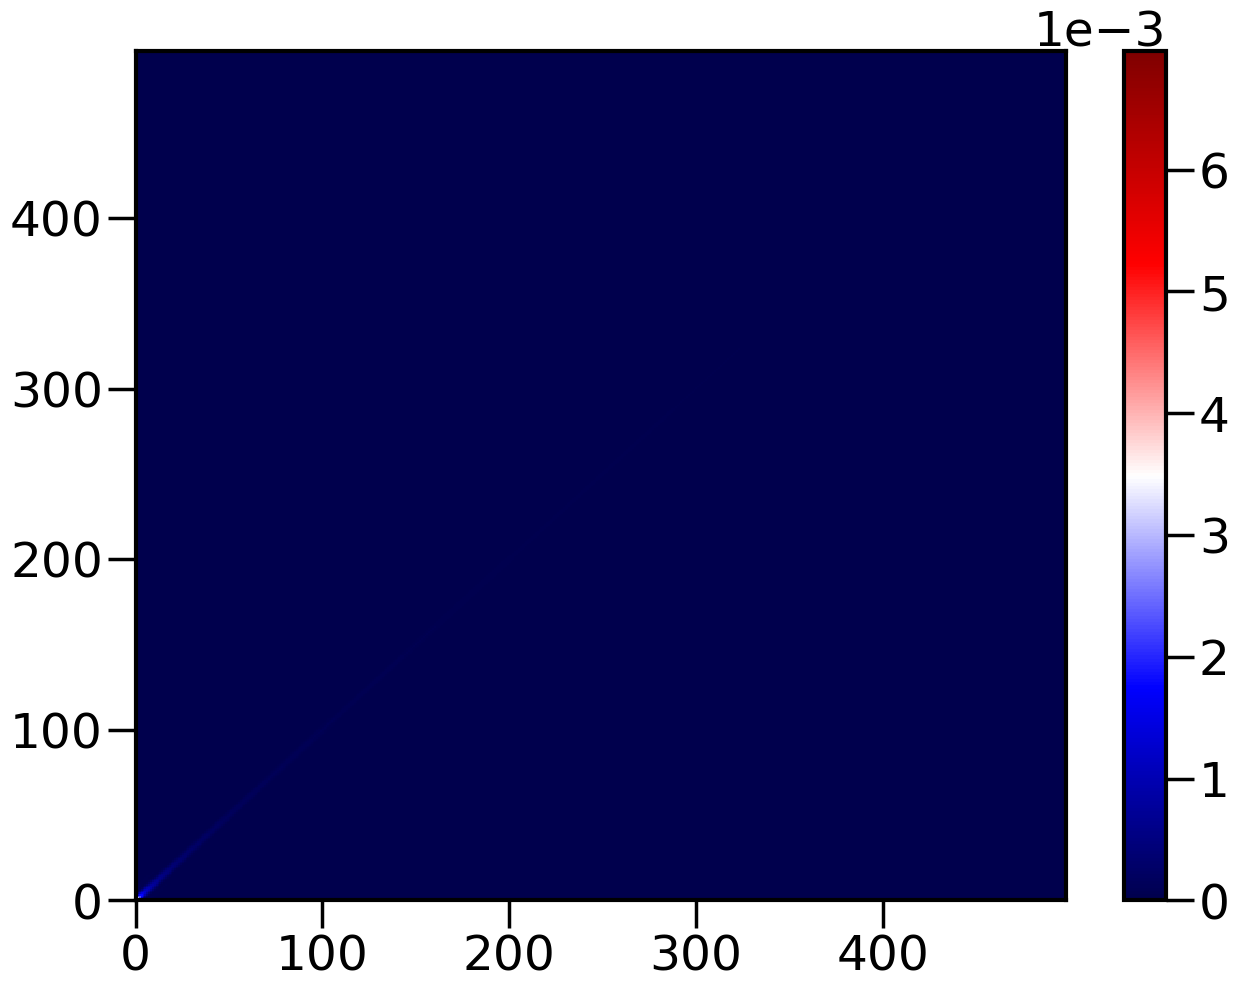

In [346]:
pcolor(win_t,cmap='seismic')
colorbar()

In [347]:
mask=zl_bins[0]['window']>-1.e10
nside=256
cl_map=hp.ma(hp.synfast(cl_t,nside=nside))
cl_map[~mask]=hp.UNSEEN
cl_t2=hp.anafast(cl_map,lmax=100)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/usr/lib/python3.7/site-packages/healpy/sphtfunc.py:390: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,


/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


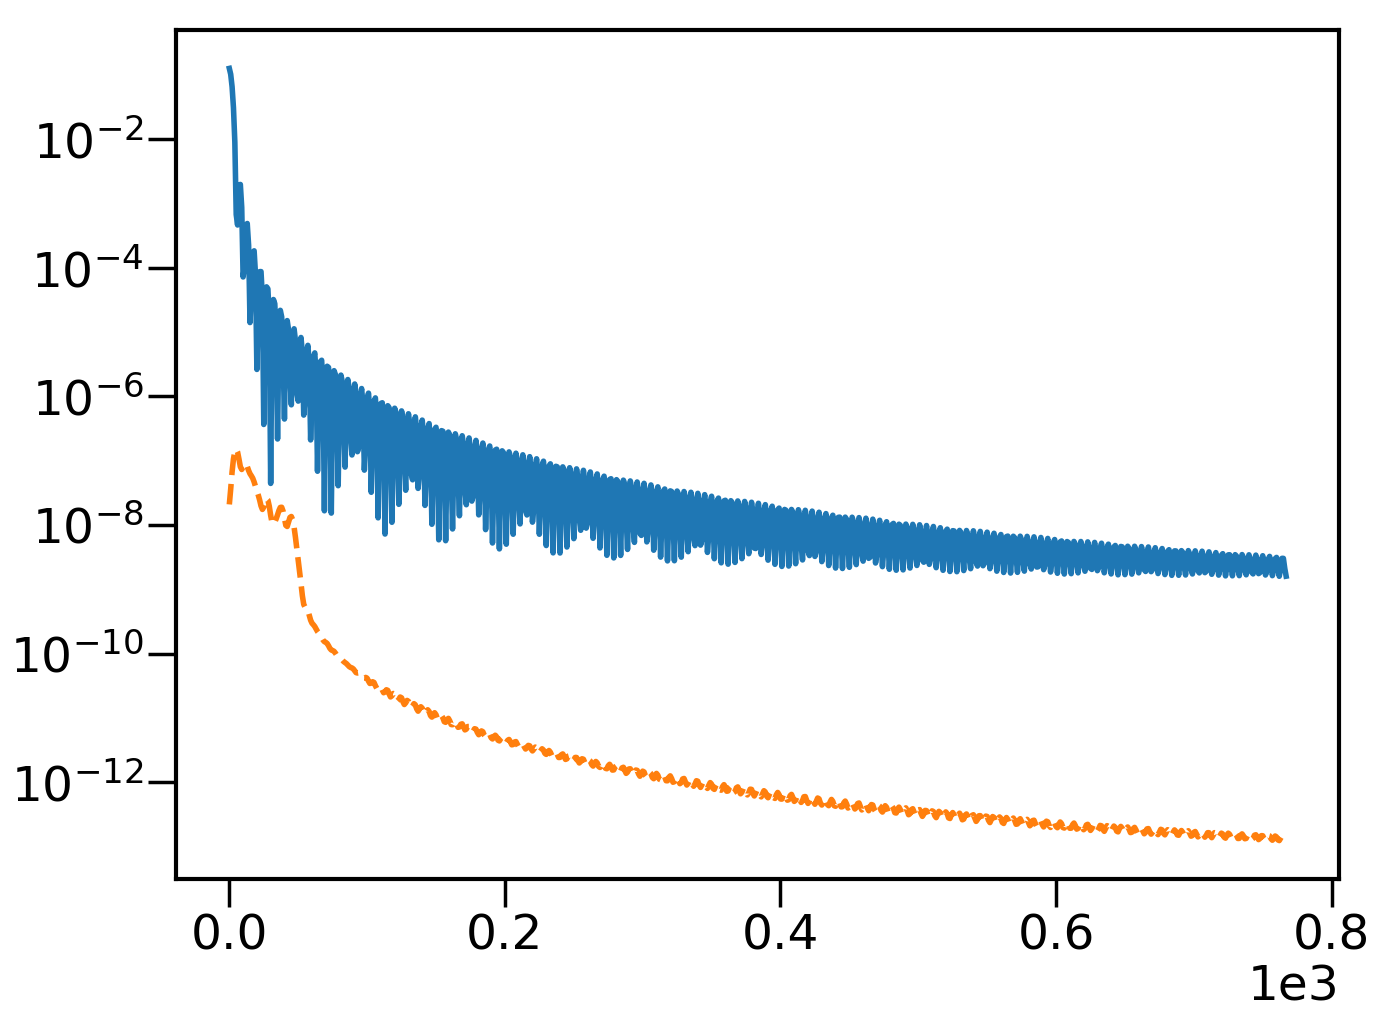

In [348]:
plot(hp.anafast(zl_bins[0]['window']))
plot(hp.anafast(zl_bins[0]['window']-1),'--')
# xscale('log')
yscale('log')

In [349]:
x=zl_bins[0]['window']>-1.e10
zl_bins[0]['window'][x].sum()/len(x)

0.1000405714648943

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


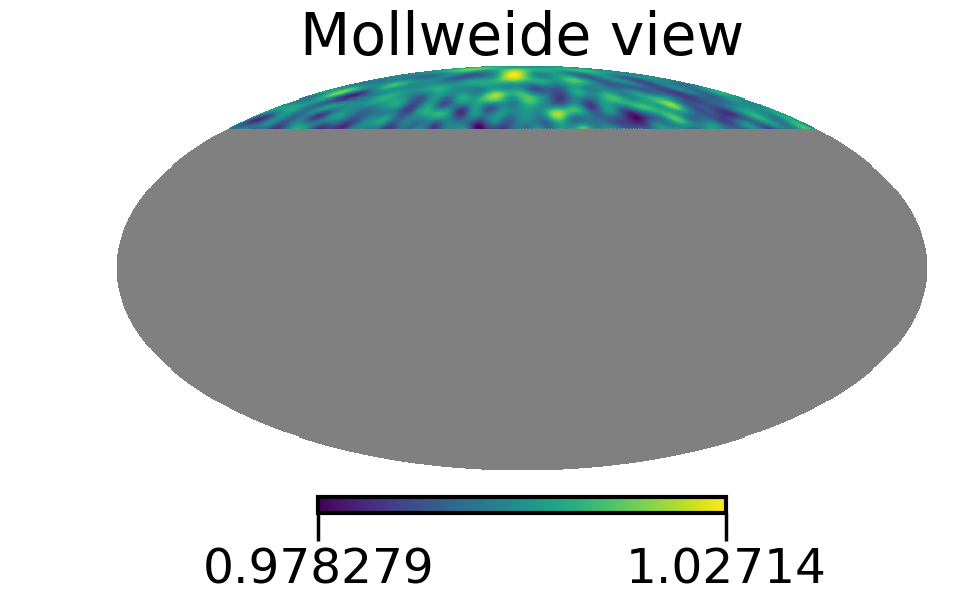

In [350]:
hp.mollview(zl_bins[0]['window'])

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


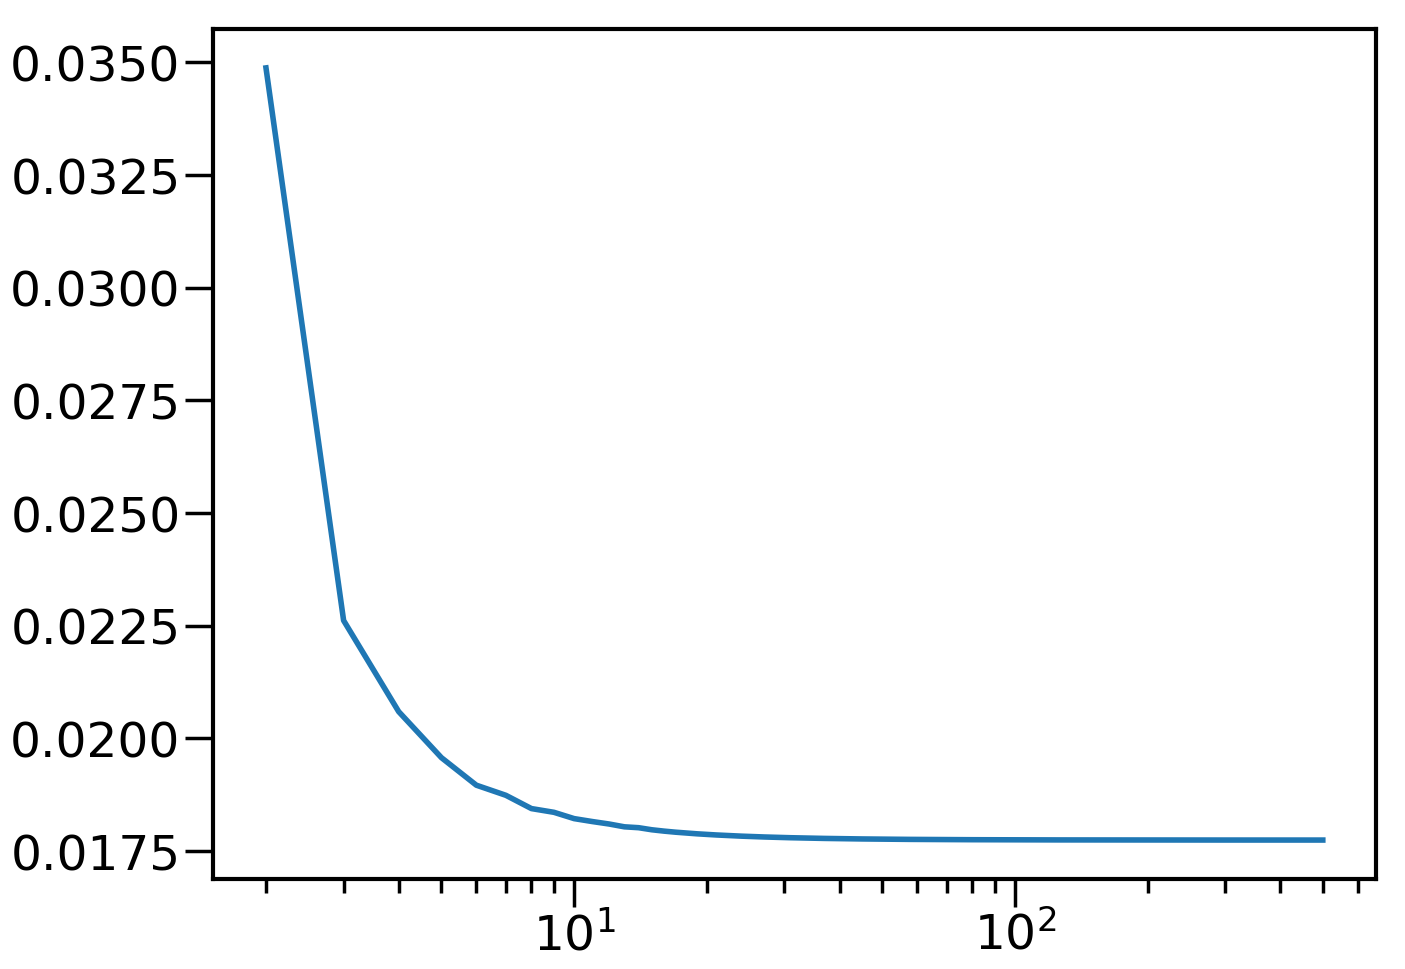

In [351]:
plot(XI_W_L.l,np.diag(win0_t))
xscale('log')
# yscale('log')

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


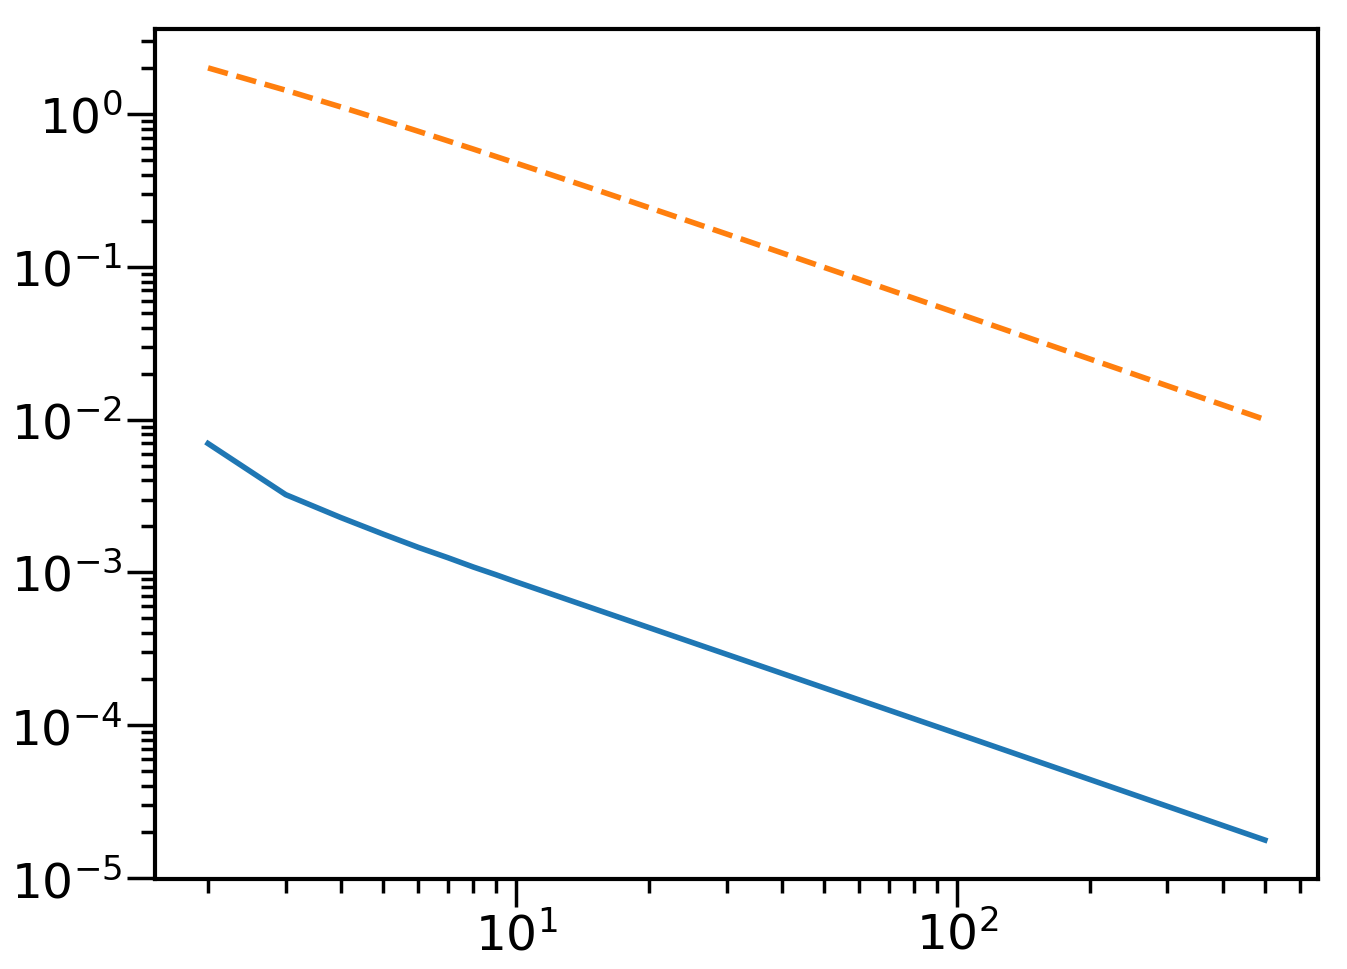

In [352]:
plot(XI_W_L.l,np.diag(win_t))
plot(XI_W_L.l,1./XI_W_L.cov_utils.gaussian_cov_norm,'--')
xscale('log')
yscale('log')

In [353]:
%time xiW_L=xiWG_L['stack'].compute()
%time xiW_L_nw=xiWG_L_nw['stack'].compute()

dict_keys(['cl', 'xi', ('shear', 'shear'), ('shear', 'galaxy'), ('galaxy', 'shear'), ('galaxy', 'galaxy'), 'cov'])dict_keys(['cl', 'xi', ('shear', 'shear'), ('shear', 'galaxy'), ('galaxy', 'shear'), ('galaxy', 'galaxy'), 'cov'])dict_keys(['cl', 'xi', ('shear', 'shear'), ('shear', 'galaxy'), ('galaxy', 'shear'), ('galaxy', 'galaxy'), 'cov'])dict_keys(['cl', 'xi', ('shear', 'shear'), ('shear', 'galaxy'), ('galaxy', 'shear'), ('galaxy', 'galaxy'), 'cov'])dict_keys(['cl', 'xi', ('shear', 'shear'), ('shear', 'galaxy'), ('galaxy', 'shear'), ('galaxy', 'galaxy'), 'cov'])dict_keys(['cl', 'xi', ('shear', 'shear'), ('shear', 'galaxy'), ('galaxy', 'shear'), ('galaxy', 'galaxy'), 'cov'])
dict_keys(['cl', 'xi', ('shear', 'shear'), ('shear', 'galaxy'), ('galaxy', 'shear'), ('galaxy', 'galaxy'), 'cov'])


dict_keys(['cl', 'xi', ('shear', 'shear'), ('shear', 'galaxy'), ('galaxy', 'shear'), ('galaxy', 'galaxy'), 'cov'])



dict_keys(['cl', 'xi', ('shear', 'shear'), ('shear', 'galaxy'), ('galaxy', 'shea

In [354]:
clG['cl_b'].keys()

dict_keys([('galaxy', 'galaxy'), ('galaxy', 'shear'), ('shear', 'galaxy'), ('shear', 'shear')])

In [355]:
XI_W_L.corrs

[('shear', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy')]

In [356]:
XI_W_L.Win.Win.keys()

dict_keys(['cl', 'xi', ('shear', 'shear'), ('shear', 'galaxy'), ('galaxy', 'shear'), ('galaxy', 'galaxy'), 'cov'])

In [357]:
%time cl_L=clG['stack'].compute()
%time cl_L_nw=clG_nw['stack'].compute()

dict_keys(['cl', 'xi', ('shear', 'shear'), ('shear', 'galaxy'), ('galaxy', 'shear'), ('galaxy', 'galaxy'), 'cov'])dict_keys(['cl', 'xi', ('shear', 'shear'), ('shear', 'galaxy'), ('galaxy', 'shear'), ('galaxy', 'galaxy'), 'cov'])dict_keys(['cl', 'xi', ('shear', 'shear'), ('shear', 'galaxy'), ('galaxy', 'shear'), ('galaxy', 'galaxy'), 'cov'])dict_keys(['cl', 'xi', ('shear', 'shear'), ('shear', 'galaxy'), ('galaxy', 'shear'), ('galaxy', 'galaxy'), 'cov'])

dict_keys(['cl', 'xi', ('shear', 'shear'), ('shear', 'galaxy'), ('galaxy', 'shear'), ('galaxy', 'galaxy'), 'cov'])

dict_keys(['cl', 'xi', ('shear', 'shear'), ('shear', 'galaxy'), ('galaxy', 'shear'), ('galaxy', 'galaxy'), 'cov'])

dict_keys(['cl', 'xi', ('shear', 'shear'), ('shear', 'galaxy'), ('galaxy', 'shear'), ('galaxy', 'galaxy'), 'cov'])dict_keys(['cl', 'xi', ('shear', 'shear'), ('shear', 'galaxy'), ('galaxy', 'shear'), ('galaxy', 'galaxy'), 'cov'])dict_keys(['cl', 'xi', ('shear', 'shear'), ('shear', 'galaxy'), ('galaxy', 'shear'

In [358]:
f=1
# cov_xiH_inv=np.linalg.inv(xiH['cov']*f)
# print (np.sqrt(np.dot(xiH['xi'],np.dot(cov_xiH_inv,xiH['xi']))))

cov_xiWL_inv=np.linalg.inv(xiW_L['cov']*f)
print (np.sqrt(np.dot(xiW_L['xi'],np.dot(cov_xiWL_inv,xiW_L['xi']))))

107602406.70750792


In [359]:
XI_W_L.l

array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 18

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


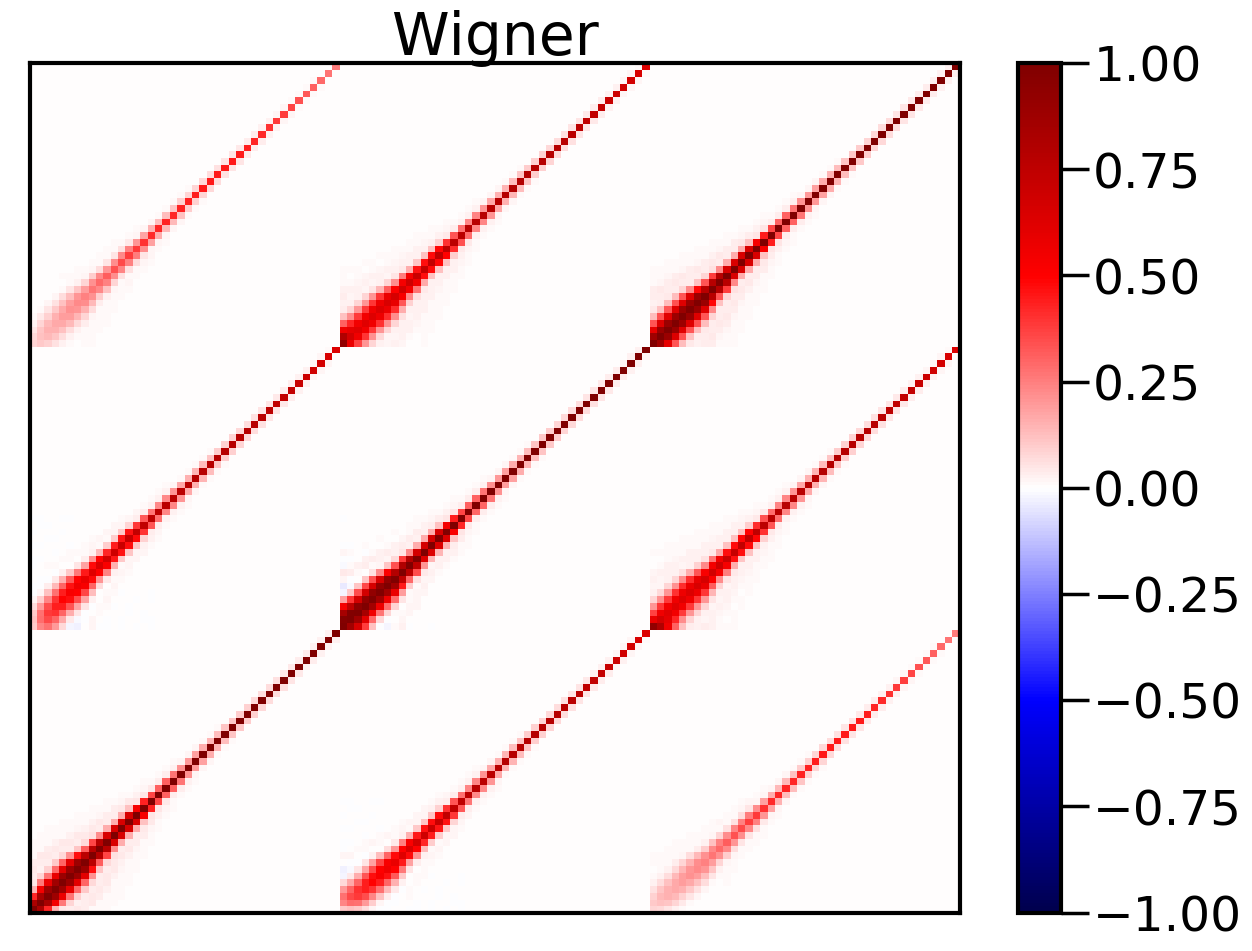

In [360]:
cc=XI_W_L.cov_utils
corrW=cc.corr_matrix(cl_L['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Wigner')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


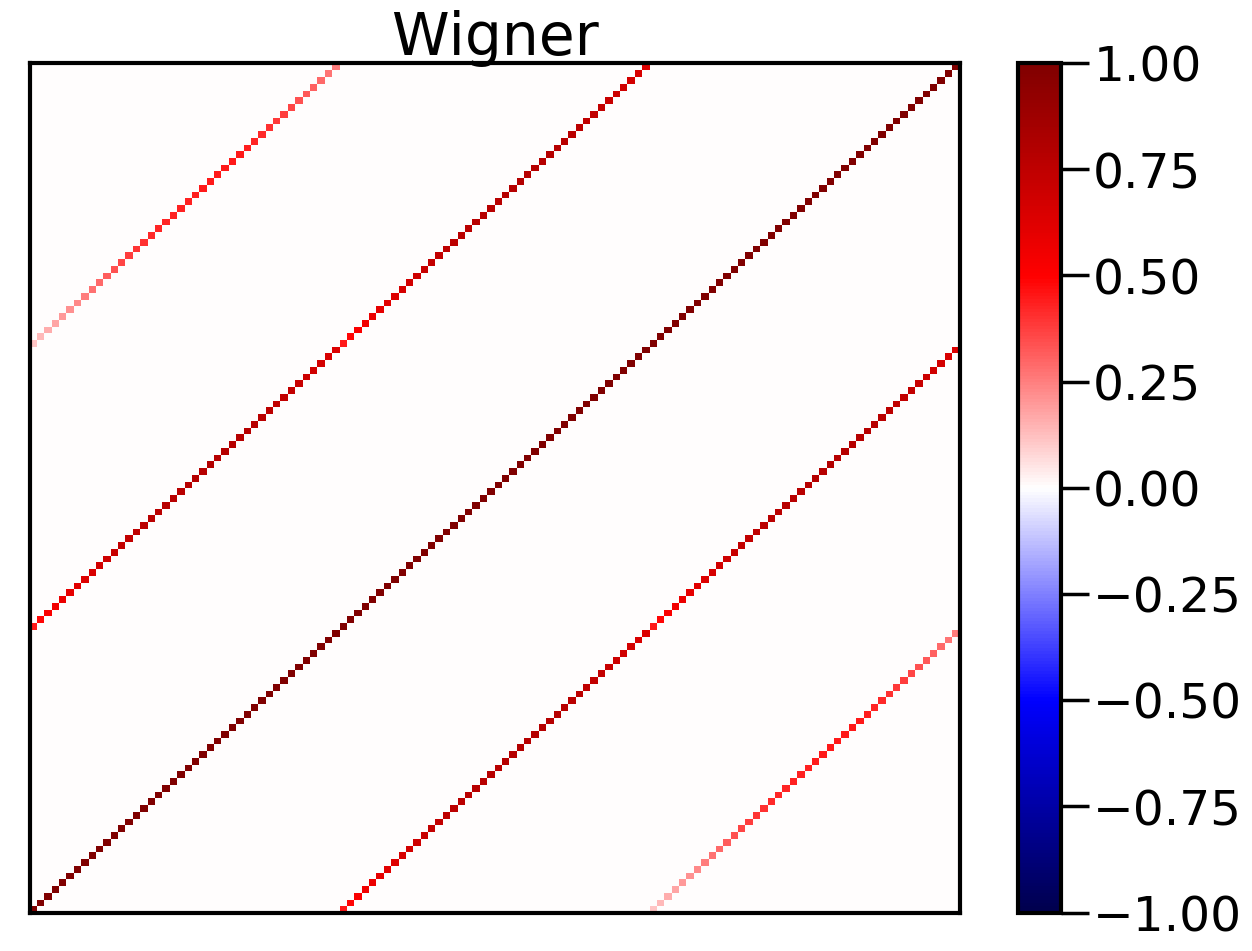

In [361]:
cc=XI_W_L.cov_utils
corrW=cc.corr_matrix(cl_L_nw['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Wigner')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


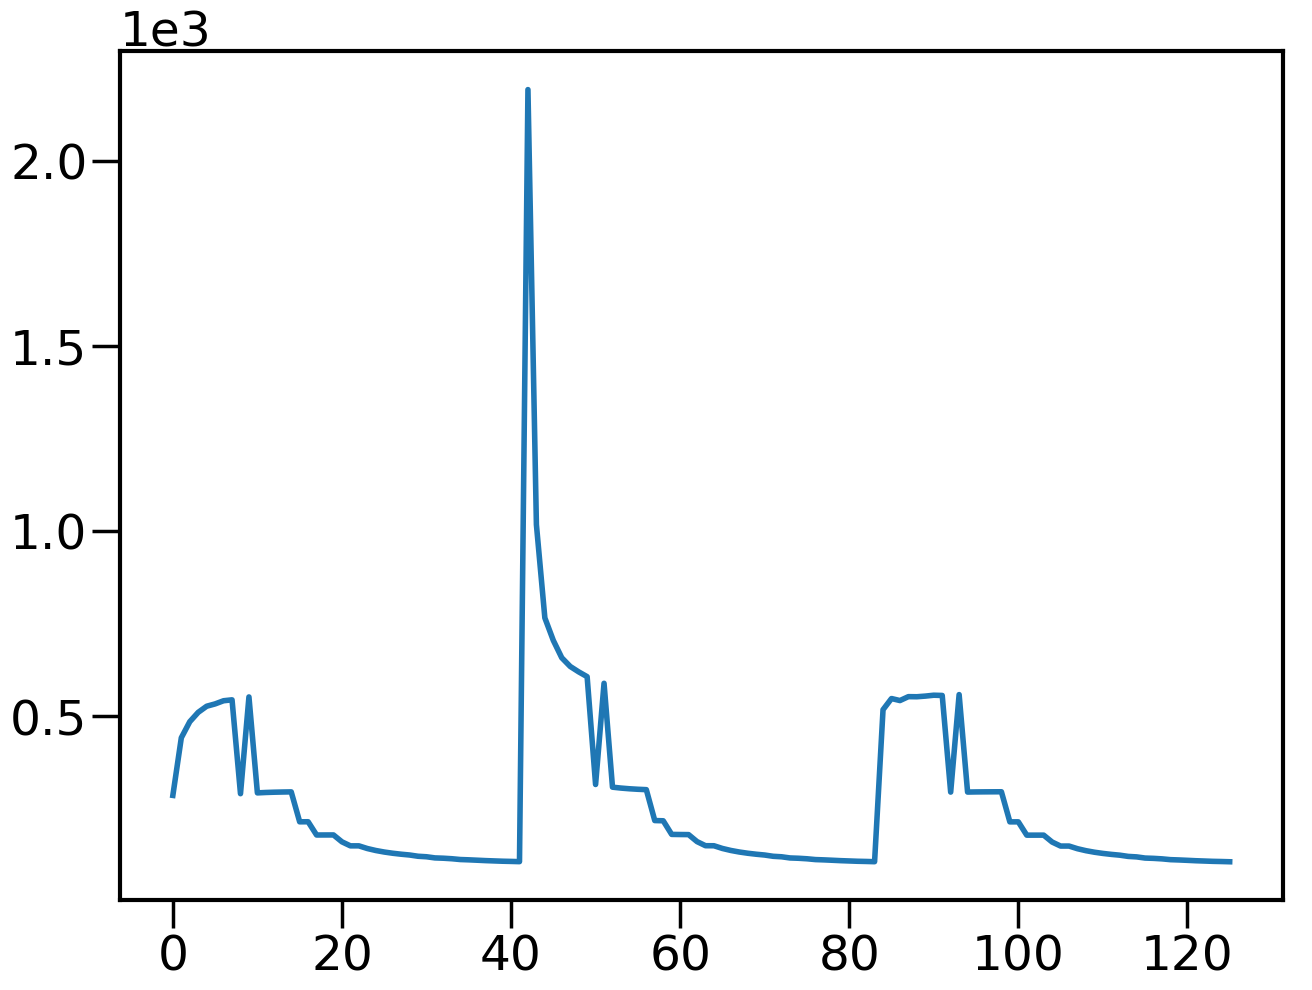

In [362]:
R=np.diag(cl_L_nw['cov']/cl_L['cov'])
plot(R)

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


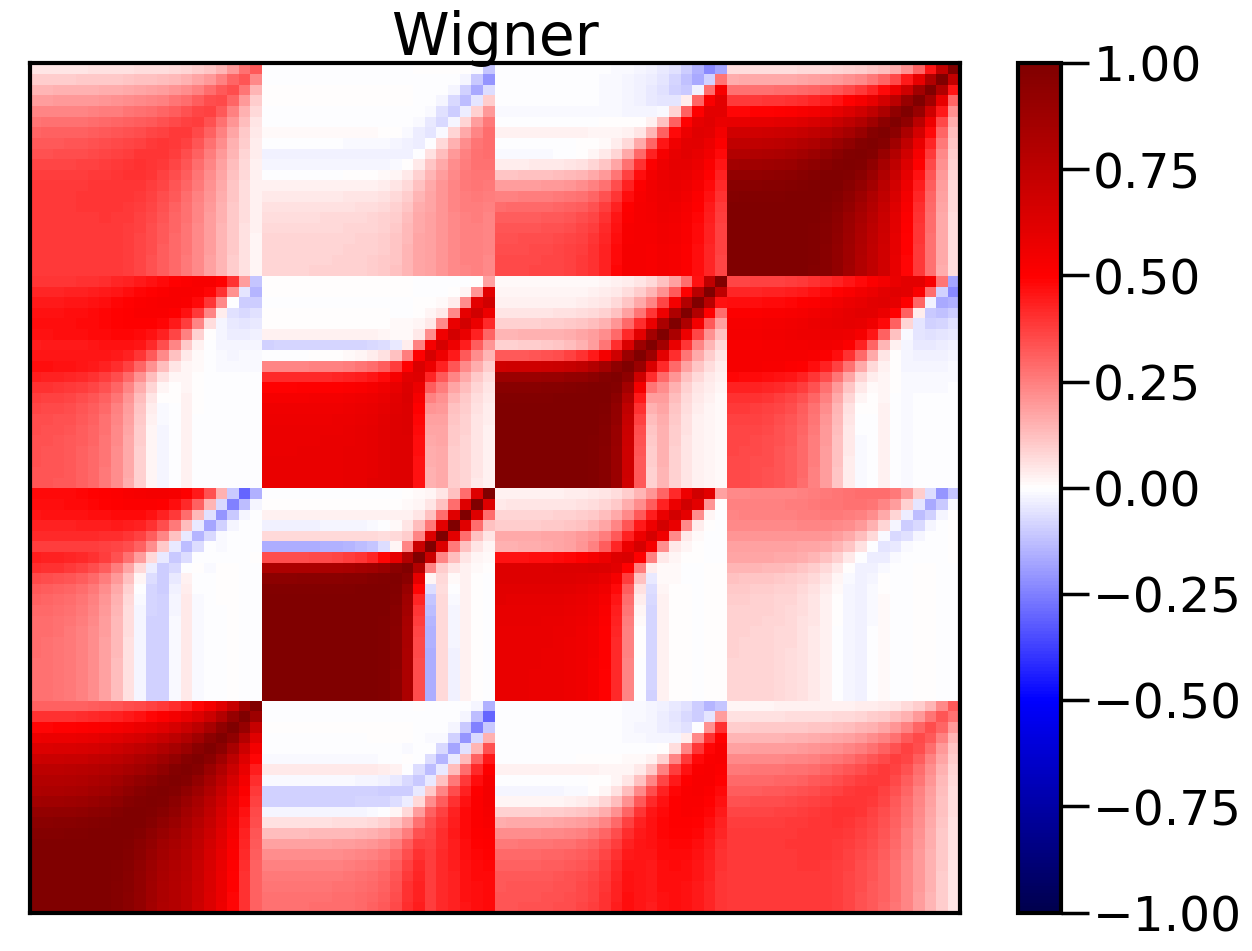

In [363]:
cc=XI_W_L.cov_utils
corrW=cc.corr_matrix(xiW_L['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Wigner')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


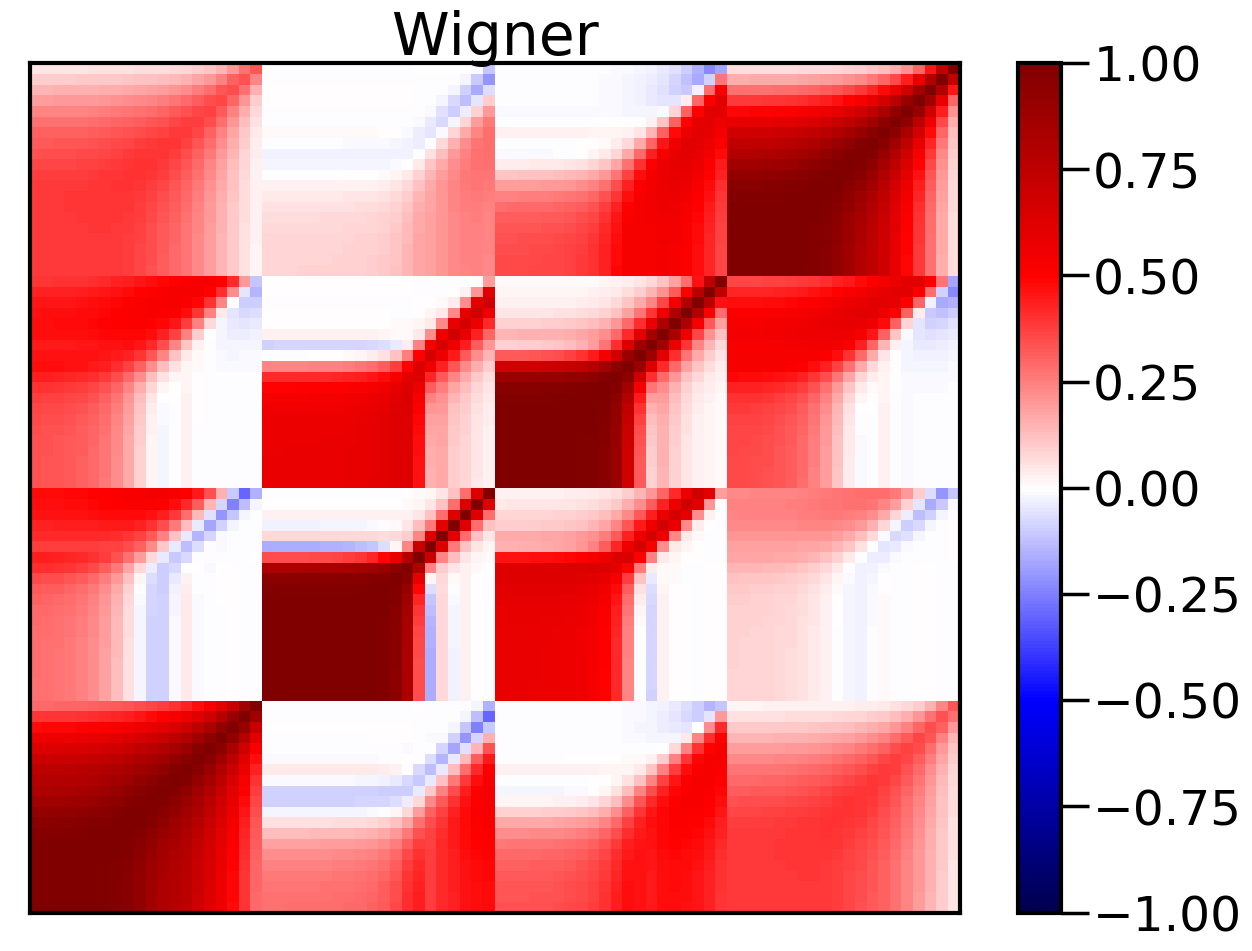

In [364]:
cc=XI_W_L.cov_utils
corrNW=cc.corr_matrix(xiW_L_nw['cov'])
pcolor(corrNW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Wigner')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


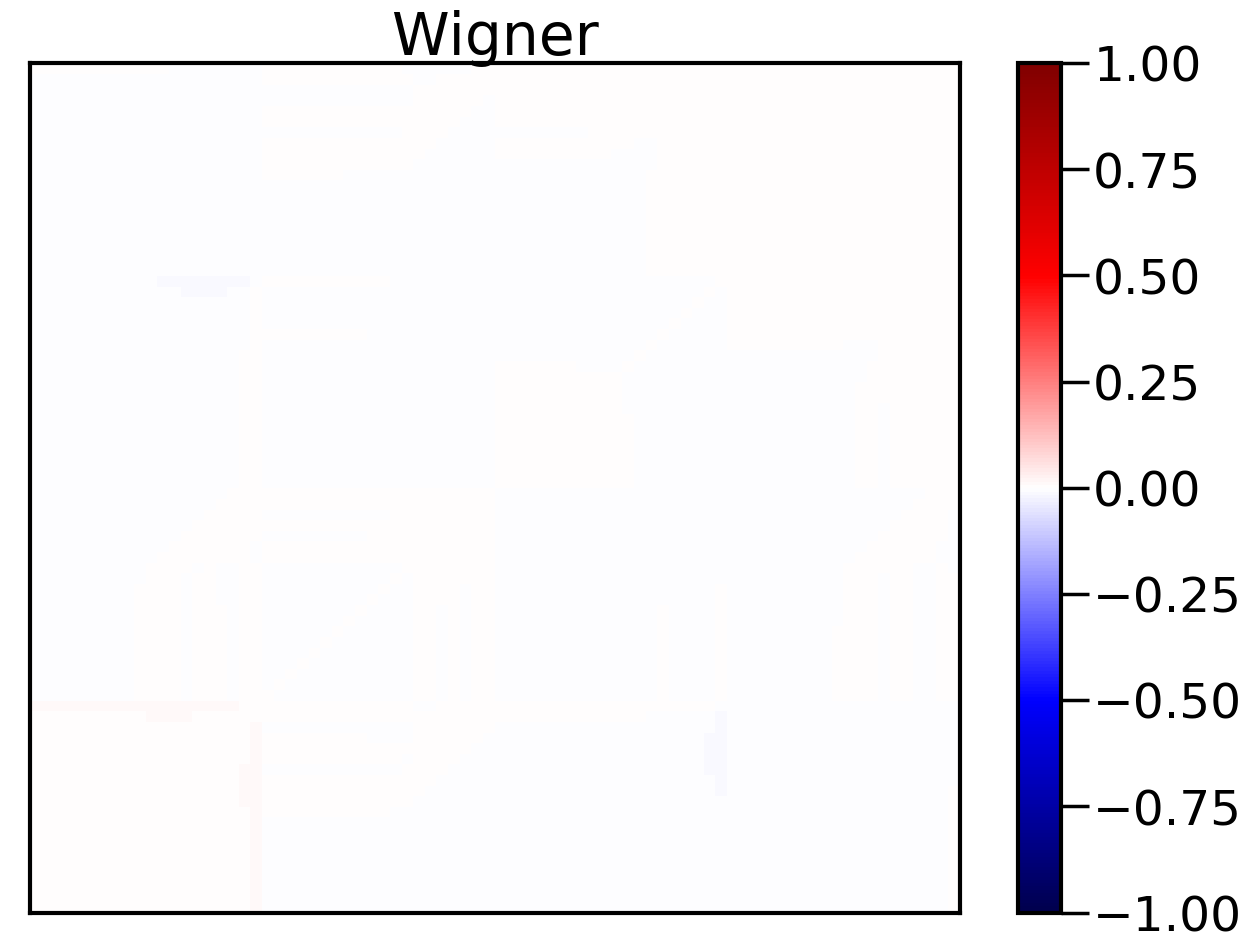

In [365]:
pcolor(corrW-corrNW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Wigner')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [366]:
np.diag(xiW_L_nw['cov'])/np.diag(xiW_L['cov'])

array([559.32552757, 559.30218037, 559.26559305, 559.20884228,
       559.12148224, 558.98956554, 558.79694962, 558.53168546,
       558.19950548, 557.82648895, 557.41701895, 556.87777251,
       556.16935464, 555.30244735, 554.1642123 , 552.70067906,
       550.8208847 , 548.39764188, 545.32879102, 541.55979265,
       563.65138106, 563.65137664, 563.65136963, 563.65135847,
       563.65134056, 563.65131161, 563.65126424, 563.6511852 ,
       563.65104906, 563.65079905, 563.65030421, 563.6491728 ,
       563.64601959, 563.63802596, 563.62739836, 563.60843971,
       563.57805717, 563.52925056, 563.45232566, 563.33132119,
       562.90336302, 562.90350383, 562.90372864, 562.90408917,
       562.90467422, 562.90563703, 562.90725677, 562.91007599,
       562.91523952, 562.92549075, 562.94700709, 562.98957322,
       563.05012851, 563.13566161, 563.26589388, 563.4601907 ,
       563.74713624, 564.17448751, 564.80322472, 565.71842738,
       561.75695003, 561.75552401, 561.75328212, 561.74